In [1]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available

True


In [2]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer
import json

In [3]:
import gc  # Adicione esta importação no início do script
from IPython import get_ipython

# 1. Remova todas as referências ao modelo e dados
if 'model' in globals():
    del model  # Remove a referência do escopo global

if 'inputs' in globals():
    del inputs

# 2. Force a coleta de lixo
gc.collect()

# 3. Limpe o cache da CUDA
torch.cuda.empty_cache()

# 4. Verifique a memória liberada
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"\n✅ GPUs disponíveis: {num_gpus}\n")

    for i in range(num_gpus):
        props = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {props.name}")
        print(f"  - Memória total: {props.total_memory / (1024 ** 3):.2f} GB")
        print(f"  - Memória livre: {torch.cuda.memory_reserved(i) / (1024 ** 3):.2f} GB (reservada)")
        print(f"  - Memória alocada: {torch.cuda.memory_allocated(i) / (1024 ** 3):.2f} GB (em uso)")
        print()
else:
    print("❌ Nenhuma GPU CUDA disponível.")


✅ GPUs disponíveis: 1

GPU 0: NVIDIA GeForce RTX 4060 Ti
  - Memória total: 15.57 GB
  - Memória livre: 0.00 GB (reservada)
  - Memória alocada: 0.00 GB (em uso)



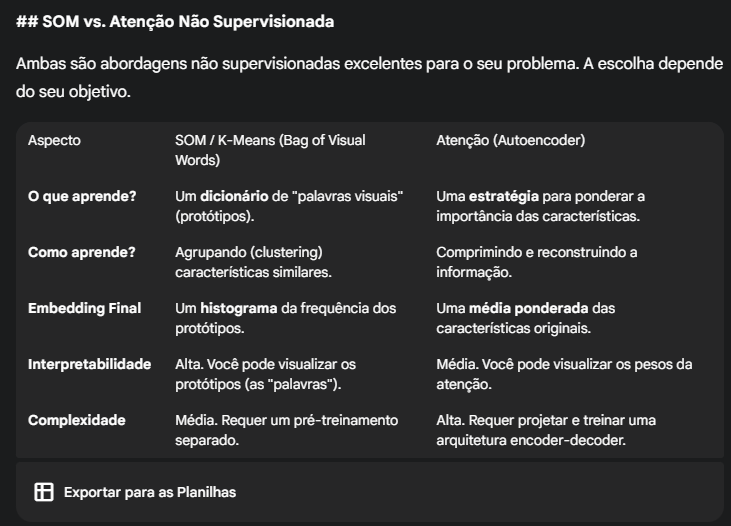

In [4]:
import os
import gc
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
import optuna
from sklearn.model_selection import train_test_split
import time


# --- 1. Dataset e DataLoader Customizados (sem mudanças) ---
class TokenDataset(Dataset):
    def __init__(self, file_paths, embeddings_dir):
        self.file_paths = file_paths
        self.embeddings_dir = embeddings_dir
    def __len__(self):
        return len(self.file_paths)
    def __getitem__(self, idx):
        full_path = os.path.join(self.embeddings_dir, self.file_paths[idx])
        # Adicionado weights_only=True para silenciar o aviso de segurança
        return torch.load(full_path, weights_only=True)

def collate_tokens(batch):
    return torch.cat(batch, dim=0)

# --- 2. Classe SOM_PyTorch (COM A CORREÇÃO DE DTYPE) ---
# --- CLASSE SOM_PyTorch (COM A CORREÇÃO FINAL) ---
class SOM_PyTorch:
    # __init__ e train_batch_from_loader como antes
    def __init__(self, x, y, input_dim, sigma=1.0, learning_rate=0.5, device='cuda'):
        self.x, self.y, self.device, self.sigma, self.learning_rate = x, y, device, sigma, learning_rate
        tensor_dtype = torch.bfloat16
        self.weights = torch.randn(x * y, input_dim, device=device, dtype=tensor_dtype)
        self.weights /= torch.norm(self.weights, p=2, dim=1, keepdim=True)
        self.locations = torch.cartesian_prod(torch.arange(x, device=device), torch.arange(y, device=device)).to(dtype=tensor_dtype)
    
    @torch.no_grad()
    def train_batch_from_loader(self, dataloader, num_epochs=5):
        initial_radius, initial_lr, total_iterations = self.sigma, self.learning_rate, num_epochs * len(dataloader)
        print(f"Treinando por {num_epochs} épocas com {len(dataloader)} lotes por época.")
        for epoch in range(num_epochs):
            for i, batch in enumerate(dataloader):
                batch = batch.to(self.device); current_iteration = epoch * len(dataloader) + i
                dists = torch.cdist(batch, self.weights); winner_indices = torch.argmin(dists, dim=1); winner_locations = self.locations[winner_indices]
                time_constant = total_iterations / np.log(initial_radius); sigma = initial_radius * torch.exp(torch.tensor(-current_iteration / time_constant)); lr = initial_lr * torch.exp(torch.tensor(-current_iteration / total_iterations))
                dist_from_winner = torch.cdist(self.locations, winner_locations); influence = torch.exp(-dist_from_winner**2 / (2 * sigma**2)) * lr
                numerator = torch.matmul(influence, batch); denominator = influence.sum(axis=1, keepdim=True)
                new_weights = numerator / (denominator + 1e-9); self.weights.copy_(new_weights)

    # --- MUDANÇA: Métricas agora aceitam um DataLoader ---
    @torch.no_grad()
    def quantization_error(self, dataloader):
        total_error = 0.
        total_samples = 0.
        for batch in dataloader:
            batch = batch.to(self.device)
            dists = torch.cdist(batch, self.weights)
            winner_dists = torch.min(dists, dim=1)[0]
            total_error += torch.sum(winner_dists).item()
            total_samples += len(batch)
        return total_error / total_samples

    @torch.no_grad()
    def topographic_error(self, dataloader):
        if self.x < 2 or self.y < 2: return 0.0
        total_error = 0.
        total_samples = 0.
        for batch in dataloader:
            batch = batch.to(self.device)
            dists = torch.cdist(batch, self.weights); _, best_two = torch.topk(dists, 2, dim=1, largest=False)
            bmu1_coords = self.locations[best_two[:, 0]]; bmu2_coords = self.locations[best_two[:, 1]]
            is_error = torch.sum(torch.abs(bmu1_coords - bmu2_coords), dim=1) > 1
            total_error += torch.sum(is_error).item()
            total_samples += len(batch)
        return total_error / total_samples

def load_tokens_from_files(file_paths, embeddings_dir):
    """Carrega tensores de uma lista de arquivos e os concatena."""
    all_tokens = []
    for f_path in tqdm(file_paths, desc="Carregando tokens"):
        full_path = os.path.join(embeddings_dir, f_path)
        if os.path.exists(full_path):
            all_tokens.append(torch.load(full_path))
    return torch.cat(all_tokens, dim=0)

# --- 3. Funções Auxiliares (sem mudança) ---
@torch.no_grad()
def create_histogram_embeddings(som_weights, doc_paths, embeddings_dir, som_x, som_y):
    histograms = []
    map_size = som_x * som_y
    for doc_path in tqdm(doc_paths, desc="Gerando Histograma de Validação"):
        full_path = os.path.join(embeddings_dir, doc_path)
        if not os.path.exists(full_path): continue
            
        tokens = torch.load(full_path).to(som_weights.device)
        dists = torch.cdist(tokens, som_weights)
        winner_indices = torch.argmin(dists, dim=1)
        histogram = torch.bincount(winner_indices, minlength=map_size).float()
        norm = torch.norm(histogram)
        if norm > 0:
            histogram /= norm
        histograms.append(histogram.cpu().numpy())
    return np.array(histograms)

# --- 5. FUNÇÃO OBJECTIVE PARA O OPTUNA (sem mudança) ---
def objective_som_intrinsic(trial):
    print(f"\n--- Iniciando Trial #{trial.number} ---")
    som_x = trial.suggest_int('som_x', 25, 40)
    som_y = som_x
    learning_rate = trial.suggest_float('learning_rate', 0.2, 1.0)
    sigma = trial.suggest_float('sigma', 2.0, som_x / 2)

    som = SOM_PyTorch(x=som_x, y=som_y, input_dim=1536, sigma=sigma, learning_rate=learning_rate, device=DEVICE)
    
    # Treinamento do SOM
    som.train_batch_from_loader(train_dataloader, num_epochs=3)

    print(f"Trial #{trial.number}: Avaliando métricas intrínsecas (em lotes)...")
    qe = som.quantization_error(val_dataloader)
    te = som.topographic_error(val_dataloader)
    
    print(f"Trial #{trial.number}: QE = {qe:.4f}, TE = {te:.4f}")

    # --- LIMPEZA DE MEMÓRIA AO FINAL DO TRIAL ---
    # Deleta explicitamente os objetos grandes que não são mais necessários
    del som
    # Força a coleta de lixo do Python
    gc.collect()
    # Libera o cache de memória da GPU que o PyTorch não está mais usando
    torch.cuda.empty_cache()
    # ----------------------------------------------
    
    return qe, te

In [5]:
# --- 4. CONFIGURAÇÃO E CARREGAMENTO DE DADOS (sem mudança) ---
EMBEDDINGS_DIR = '/mnt/data/embeddings'
MANIFEST_CSV = '../data/sampled_dataset_png/manifest_linux.csv'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("--- Iniciando verificação de embeddings existentes ---")

# --- MUDANÇA PRINCIPAL AQUI ---
# 1. Vamos escanear o diretório de embeddings para encontrar os arquivos que REALMENTE existem.
all_existing_embeddings = []
# Usamos os.walk para percorrer todos os subdiretórios de forma eficiente
for root, dirs, files in tqdm(os.walk(EMBEDDINGS_DIR), desc="Escaneando embeddings"):
    for file in files:
        if file.endswith('.pt'):
            # Adicionamos o caminho RELATIVO, a partir de EMBEDDINGS_DIR
            full_path = os.path.join(root, file)
            relative_path = os.path.relpath(full_path, EMBEDDINGS_DIR)
            all_existing_embeddings.append(relative_path)

if not all_existing_embeddings:
    print("❌ Erro: Nenhum arquivo de embedding .pt foi encontrado no diretório de embeddings.")
    exit()

print(f"✅ Encontrados {len(all_existing_embeddings)} embeddings processados com sucesso.")

# 2. Agora, dividimos a lista de arquivos EXISTENTES em treino e validação
train_files, val_files = train_test_split(all_existing_embeddings, test_size=0.2, random_state=42)
# ------------------------------------

print(f"Total de documentos a serem usados: {len(all_existing_embeddings)}")
print(f"Documentos para treino do SOM: {len(train_files)}")
print(f"Documentos para validação: {len(val_files)}")

# O resto do código continua como antes, agora usando as listas de arquivos seguras
train_dataset = TokenDataset(train_files, EMBEDDINGS_DIR)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_tokens, num_workers=0)

val_dataset = TokenDataset(val_files, EMBEDDINGS_DIR)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False, collate_fn=collate_tokens, num_workers=0)
print("DataLoaders de treino e validação criados com sucesso.")

--- Iniciando verificação de embeddings existentes ---


Escaneando embeddings: 13795it [00:00, 42730.97it/s]

✅ Encontrados 9884 embeddings processados com sucesso.
Total de documentos a serem usados: 9884
Documentos para treino do SOM: 7907
Documentos para validação: 1977
DataLoaders de treino e validação criados com sucesso.


In [6]:
# --- 5. EXECUÇÃO DO ESTUDO MULTIOBJETIVO ---
print("\n--- INICIANDO O ESTUDO DE OTIMIZAÇÃO MULTIOBJETIVO (QE e TE) ---")
# Criamos um estudo com duas direções: minimizar e minimizar
study = optuna.create_study(
    directions=['minimize', 'minimize'], 
    storage='sqlite:///som_optimization.db', 
    study_name='som_qe_te_v1', 
    load_if_exists=True
)
study.optimize(objective_som_intrinsic, n_trials=20)

print("\n--- Otimização Concluída! ---")

[I 2025-08-20 23:37:25,827] Using an existing study with name 'som_qe_te_v1' instead of creating a new one.



--- INICIANDO O ESTUDO DE OTIMIZAÇÃO MULTIOBJETIVO (QE e TE) ---


NameError: name 'objective_som_intrinsic' is not defined

In [1]:
import optuna

# Carregue o estudo que você acabou de rodar
study = optuna.load_study(
    study_name='som_qe_te_v1',
    storage='sqlite:///som_optimization.db'
)

# Gere o gráfico da Fronteira de Pareto
# Os eixos serão 'Objective 0' (QE) e 'Objective 1' (TE)
fig = optuna.visualization.plot_pareto_front(study)
fig.show()

# Para ver os melhores trials
print("Melhores trials (fronteira de Pareto):")
for trial in study.best_trials:
    print(f"  Trial {trial.number}:")
    print(f"    Valores: QE={trial.values[0]:.4f}, TE={trial.values[1]:.4f}")
    print(f"    Parâmetros: {trial.params}")

Melhores trials (fronteira de Pareto):
  Trial 8:
    Valores: QE=83.7530, TE=0.1434
    Parâmetros: {'som_x': 20, 'learning_rate': 0.4458430060507797, 'sigma': 4.158379793988146}
  Trial 9:
    Valores: QE=86.8953, TE=0.1095
    Parâmetros: {'som_x': 12, 'learning_rate': 0.5804363107654127, 'sigma': 3.2065591797673307}
  Trial 11:
    Valores: QE=83.9625, TE=0.1408
    Parâmetros: {'som_x': 21, 'learning_rate': 0.9112920402402638, 'sigma': 8.609232223335699}
  Trial 13:
    Valores: QE=84.3814, TE=0.1407
    Parâmetros: {'som_x': 19, 'learning_rate': 0.8950846179754124, 'sigma': 3.728263483985197}
  Trial 15:
    Valores: QE=81.3229, TE=0.1829
    Parâmetros: {'som_x': 34, 'learning_rate': 0.6790263405076646, 'sigma': 16.69340182428637}
  Trial 16:
    Valores: QE=80.0660, TE=0.2143
    Parâmetros: {'som_x': 41, 'learning_rate': 0.2625963724805585, 'sigma': 5.0213754233398795}
  Trial 23:
    Valores: QE=80.7783, TE=0.2084
    Parâmetros: {'som_x': 38, 'learning_rate': 0.9203968503626

In [19]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from collections import Counter

# --- Configuração ---
MANIFEST_CSV = '../data/sampled_dataset_png/manifest_linux.csv'
EMBEDDINGS_DIR = '/mnt/data/embeddings'

# --- 2. EXECUÇÃO DA ANÁLISE ---
print("Iniciando verificação abrangente dos shapes dos embeddings...")

try:
    df = pd.read_csv(MANIFEST_CSV)
    # Gera a lista de caminhos relativos para os arquivos .pt
    embedding_files = df['filepath'].str.replace('.png', '.pt').tolist()
    print(f"Encontrados {len(embedding_files)} arquivos para verificar no manifesto.")
except FileNotFoundError:
    print(f"❌ Erro: Arquivo de manifesto '{MANIFEST_CSV}' não encontrado.")
    exit()

# Usamos um Counter para contar as ocorrências de cada shape
shape_counts = Counter()

# tqdm cria uma barra de progresso para a verificação
for relative_path in tqdm(embedding_files, desc="Verificando arquivos"):
    full_path = os.path.join(EMBEDDINGS_DIR, relative_path)
    
    if not os.path.exists(full_path):
        # Se um embedding não foi gerado, apenas pula
        continue
    
    try:
        # Carrega o tensor do disco.
        # Adicionado weights_only=True para segurança e para suprimir o aviso que você viu.
        tensor = torch.load(full_path, weights_only=True)
        
        # Adiciona a tupla da shape (ex: (3506, 1536)) ao Counter
        shape_counts[tensor.shape] += 1
    except Exception as e:
        print(f"\n❌ Erro ao carregar o arquivo {full_path}: {e}")

# --- 3. EXIBIÇÃO DOS RESULTADOS ---
print("\n--- Análise de Shapes Concluída ---")

if not shape_counts:
    print("Nenhum embedding foi carregado com sucesso.")
elif len(shape_counts) == 1:
    shape, count = list(shape_counts.items())[0]
    print(f"✅ Todos os {count} embeddings têm o mesmo shape: {shape}")
else:
    print(f"⚠️  Foram encontrados {len(shape_counts)} shapes diferentes. Contagem de cada um:")
    
    # Ordena os shapes pelo número de ocorrências (do mais comum para o menos comum)
    sorted_shapes = shape_counts.most_common()
    
    for shape, count in sorted_shapes:
        print(f"  - Shape: {str(shape):<25} | Ocorrências: {count}")

Iniciando verificação abrangente dos shapes dos embeddings...
Encontrados 9885 arquivos para verificar no manifesto.


Verificando arquivos: 100%|██████████| 9885/9885 [04:46<00:00, 34.47it/s]


--- Análise de Shapes Concluída ---
⚠️  Foram encontrados 8 shapes diferentes. Contagem de cada um:
  - Shape: torch.Size([3506, 1536])  | Ocorrências: 7501
  - Shape: torch.Size([1970, 1536])  | Ocorrências: 1714
  - Shape: torch.Size([2482, 1536])  | Ocorrências: 281
  - Shape: torch.Size([2994, 1536])  | Ocorrências: 230
  - Shape: torch.Size([946, 1536])   | Ocorrências: 115
  - Shape: torch.Size([1202, 1536])  | Ocorrências: 27
  - Shape: torch.Size([1458, 1536])  | Ocorrências: 12
  - Shape: torch.Size([2738, 1536])  | Ocorrências: 4


In [ ]:
import optuna

# Caminho para o banco de dados, no formato que o Optuna espera
STORAGE_DB = 'sqlite:///som_optimization.db'

print("--- Resumo de Todos os Estudos Salvos ---")
# Carrega um resumo de todos os estudos no arquivo
all_studies = optuna.get_all_study_summaries(storage=STORAGE_DB)

for study_summary in all_studies:
    print(f"\nEstudo: '{study_summary.study_name}'")
    print(f"  - Número de Trials: {study_summary.n_trials}")
    print(f"  - Direções de Otimização: {[d.name for d in study_summary.directions]}")

# Vamos carregar um estudo específico e ver os detalhes dos seus trials
# Substitua 'som_qe_te_v1' pelo nome do estudo que você quer analisar
STUDY_NAME_TO_LOAD = 'som_qe_te_v1' 

print(f"\n--- Detalhes dos Trials do Estudo '{STUDY_NAME_TO_LOAD}' ---")
study = optuna.load_study(
    study_name=STUDY_NAME_TO_LOAD,
    storage=STORAGE_DB
)

# Acessa a lista de todos os trials e imprime os detalhes dos 5 primeiros
for trial in study.trials[:5]:
    print(f"\nTrial #{trial.number}:")
    print(f"  - Estado: {trial.state}")
    if trial.values: # Checa se o trial foi concluído com sucesso
        print(f"  - Valores (QE, TE): {trial.values}")
    print(f"  - Parâmetros: {trial.params}")

--- Resumo de Todos os Estudos Salvos ---

Estudo: 'som_hyperparams_v1'
  - Número de Trials: 51
  - Direções de Otimização: ['MAXIMIZE']

Estudo: 'som_large_scale_v1'
  - Número de Trials: 2
  - Direções de Otimização: ['MAXIMIZE']

Estudo: 'som_qe_te_v1'
  - Número de Trials: 50
  - Direções de Otimização: ['MINIMIZE', 'MINIMIZE']

Estudo: 'som_qe_te_sil_v1'
  - Número de Trials: 56
  - Direções de Otimização: ['MINIMIZE', 'MINIMIZE', 'MAXIMIZE']

--- Detalhes dos Trials do Estudo 'som_qe_te_v1' ---

Trial #0:
  - Estado: 3
  - Parâmetros: {'som_x': 30, 'learning_rate': 0.871336302805015, 'sigma': 10.192542649308017}

Trial #1:
  - Estado: 3
  - Parâmetros: {'som_x': 44, 'learning_rate': 0.4234843478114013, 'sigma': 3.046285822431845}

Trial #2:
  - Estado: 3
  - Parâmetros: {'som_x': 21, 'learning_rate': 0.8057304207482767, 'sigma': 10.415776736441032}

Trial #3:
  - Estado: 0
  - Parâmetros: {'som_x': 28, 'learning_rate': 0.5610606927486774, 'sigma': 9.695806322745781}

Trial #4:
 

In [12]:
import optuna
import pandas as pd

# Carregue o seu estudo
study = optuna.load_study(
    study_name='som_qe_te_v1', # Use o nome do estudo que você quer analisar
    storage='sqlite:///som_optimization.db'
)

# O Optuna pode converter todos os trials em um DataFrame do Pandas
df_trials = study.trials_dataframe()

# Defina o range de parâmetros que você considera "válido"
# Com base no seu último script, o range final era de 25 a 42
VALID_SOM_X_MIN = 25
VALID_SOM_X_MAX = 42

# Filtra o DataFrame para manter apenas os trials consistentes
# O Optuna nomeia as colunas de parâmetros como 'params_NOME_DO_PARAMETRO'
consistent_trials_df = df_trials[
    (df_trials['params_som_x'] >= VALID_SOM_X_MIN) &
    (df_trials['params_som_x'] <= VALID_SOM_X_MAX)
]

# Filtra para ver quais são os inconsistentes
inconsistent_trials_df = df_trials[
    (df_trials['params_som_x'] < VALID_SOM_X_MIN) |
    (df_trials['params_som_x'] > VALID_SOM_X_MAX)
]


print(f"Total de trials no estudo: {len(df_trials)}")
print(f"Trials consistentes (som_x entre {VALID_SOM_X_MIN}-{VALID_SOM_X_MAX}): {len(consistent_trials_df)}")
print(f"Trials inconsistentes encontrados: {len(inconsistent_trials_df)}")

print("\n--- Amostra de Trials Inconsistentes ---")
# Mostra as colunas relevantes dos trials que você quer ignorar
if not inconsistent_trials_df.empty:
    print(inconsistent_trials_df[['number', 'values_0', 'values_1', 'params_som_x']])

# A partir daqui, você pode usar o 'consistent_trials_df' para todas as suas análises e visualizações.

Total de trials no estudo: 50
Trials consistentes (som_x entre 25-42): 41
Trials inconsistentes encontrados: 9

--- Amostra de Trials Inconsistentes ---
    number   values_0  values_1  params_som_x
1        1        NaN       NaN            44
2        2        NaN       NaN            21
7        7        NaN       NaN            50
8        8  83.752987  0.143388            20
9        9  86.895295  0.109516            12
11      11  83.962474  0.140814            21
13      13  84.381449  0.140722            19
14      14        NaN       NaN            50
22      22  80.275499  0.240357            44


In [14]:
dados = pd.read_csv('../data/sampled_dataset_png/manifest_linux.csv')
dados[dados['filepath'].str.contains('Datasets/DIVA-HisDB/img-CB55/img/training/e-codices_fmb-cb-0055_0072v_max.png')]

,filepath,extension,source,subcategory
100,Datasets/DIVA-HisDB/img-CB55/img/training/e-co...,png,DIVA-HisDB,NaN


In [15]:
import pandas as pd

# --- 1. CONFIGURAÇÃO ---
# O caminho para o seu arquivo de manifesto
manifest_path = '../data/sampled_dataset_png/manifest_linux.csv'

# O trecho do caminho do arquivo problemático que você quer remover
# (copiado da sua célula de verificação)
problematic_filepath_part = 'Datasets/DIVA-HisDB/img-CB55/img/training/e-codices_fmb-cb-0055_0072v_max.png'

# --- 2. EXECUÇÃO DA LIMPEZA ---
try:
    # Carrega o CSV para um DataFrame do Pandas
    df = pd.read_csv(manifest_path)
    original_row_count = len(df)
    print(f"Arquivo '{manifest_path}' carregado com {original_row_count} linhas.")
    
    # Cria uma condição booleana para encontrar a(s) linha(s) problemática(s)
    condition_to_drop = df['filepath'].str.contains(problematic_filepath_part, na=False)
    
    # Conta quantas linhas correspondem à condição
    num_rows_to_drop = condition_to_drop.sum()
    
    if num_rows_to_drop > 0:
        print(f"Encontrada(s) {num_rows_to_drop} linha(s) para remover contendo: '{problematic_filepath_part}'")
        
        # Inverte a condição (usando o ~) para manter todas as outras linhas
        df_cleaned = df[~condition_to_drop]
        
        # Salva o DataFrame limpo de volta no mesmo arquivo
        # O argumento index=False é crucial para não criar uma coluna de índice extra
        df_cleaned.to_csv(manifest_path, index=False)
        
        print(f"Arquivo salvo com sucesso! Novo total de linhas: {len(df_cleaned)}")
    else:
        print("Nenhuma linha correspondente ao caminho problemático foi encontrada. O arquivo não foi modificado.")

except FileNotFoundError:
    print(f"❌ Erro: O arquivo de entrada '{manifest_path}' não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Arquivo '../data/sampled_dataset_png/manifest_linux.csv' carregado com 9885 linhas.
Encontrada(s) 1 linha(s) para remover contendo: 'Datasets/DIVA-HisDB/img-CB55/img/training/e-codices_fmb-cb-0055_0072v_max.png'
Arquivo salvo com sucesso! Novo total de linhas: 9884
